<a href="https://colab.research.google.com/github/ntshvicky/AimlChatbot/blob/master/Muasic_Genere_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required libraries
!pip install librosa tensorflow matplotlib scikit-learn

In [2]:
# Download the dataset (uncomment if running on Colab)
!wget -O genres.tar.gz "https://www.dropbox.com/s/4jw31k5mlzcmgis/genres.tar.gz?dl=1"

# Extract the dataset
import tarfile
with tarfile.open("genres.tar.gz", "r:gz") as tar:
    tar.extractall(path=".")
print("Dataset extracted!")

--2025-01-25 11:28:01--  https://www.dropbox.com/s/4jw31k5mlzcmgis/genres.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/logv7hsjc1t3daaysuhyh/genres.tar.gz?rlkey=vcu3jvliyletkjwxz8bv8jm7c&dl=1 [following]
--2025-01-25 11:28:02--  https://www.dropbox.com/scl/fi/logv7hsjc1t3daaysuhyh/genres.tar.gz?rlkey=vcu3jvliyletkjwxz8bv8jm7c&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc26d7eec605ce6227ee7fedb50a.dl.dropboxusercontent.com/cd/0/inline/Ci3loFkX3KD0Wc4-RnwXLNJNK-rMxYJLJBDsjichZ4eit22hN4iiRHRHkcRZ2K_3CqHkQCj8xea1zO3X4vBiVOYmp61uRoaq96VhsfgHv8k9S5149YOTU4L_Fol2KYhwv_g/file?dl=1# [following]
--2025-01-25 11:28:02--  https://uc26d7eec605ce6227ee7fedb50a.dl.dropboxusercontent.com/cd/0/inline

In [3]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [4]:
# Path to the dataset
DATASET_PATH = "./genres"
SR = 22050  # Sampling rate
N_MELS = 128  # Number of Mel bands
DURATION = 30  # Duration of each audio clip in seconds
MAX_LEN = 128  # Fixed length for spectrogram (time dimension)

In [5]:
def extract_features(file_path, sr=SR, n_mels=N_MELS, duration=DURATION, max_len=MAX_LEN):
    """Extract Mel-spectrogram features and ensure a fixed shape."""
    try:
        audio, _ = librosa.load(file_path, sr=sr, duration=duration)
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # Pad or truncate to ensure fixed shape
        if mel_spec_db.shape[1] < max_len:
            pad_width = max_len - mel_spec_db.shape[1]
            mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mel_spec_db = mel_spec_db[:, :max_len]

        return mel_spec_db
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Load dataset
def load_data(dataset_path):
    features, labels = [], []
    for genre in os.listdir(dataset_path):
        genre_path = os.path.join(dataset_path, genre)
        if os.path.isdir(genre_path):
            for file in os.listdir(genre_path):
                file_path = os.path.join(genre_path, file)
                mel_spec = extract_features(file_path)
                if mel_spec is not None:
                    features.append(mel_spec)
                    labels.append(genre)
    return np.array(features), np.array(labels)

In [6]:
# Load data
print("Loading data...")
features, labels = load_data(DATASET_PATH)

Loading data...


In [7]:
# Encoding labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)
categorical_labels = to_categorical(encoded_labels)

In [8]:
# Reshape features for CNN
features = features[..., np.newaxis]  # Add channel dimension

In [9]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features, categorical_labels, test_size=0.2, random_state=42)

print(f"Data loaded: {X_train.shape[0]} training samples, {X_val.shape[0]} validation samples")

Data loaded: 800 training samples, 200 validation samples


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization


In [11]:

# Build the CNN model
def build_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
# Model parameters
input_shape = X_train.shape[1:]  # (n_mels, time, 1)
num_classes = len(le.classes_)

In [13]:
# Build the model
model = build_model(input_shape, num_classes)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
# Train the model
BATCH_SIZE = 32
EPOCHS = 100

In [16]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 0.1431 - loss: 8.3829 - val_accuracy: 0.1150 - val_loss: 4.5263
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.1293 - loss: 2.2751 - val_accuracy: 0.1250 - val_loss: 2.7570
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1540 - loss: 2.2120 - val_accuracy: 0.1100 - val_loss: 2.9463
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1599 - loss: 2.2284 - val_accuracy: 0.0850 - val_loss: 5.0629
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.1761 - loss: 2.1484 - val_accuracy: 0.1000 - val_loss: 8.0821
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.1637 - loss: 2.1781 - val_accuracy: 0.0950 - val_loss: 11.7774
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.1544 - loss: 2.2471 - val_accuracy: 0.1400 - val_loss: 7.5646
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.2058 - loss: 2.1585 - val_accuracy

In [17]:
# Save the model and label encoder
model.save("music_genre_model.h5")
np.save("label_encoder.npy", le.classes_)

In [18]:
# Evaluate the model
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3617 - loss: 2.4736 
Validation Accuracy: 35.00%


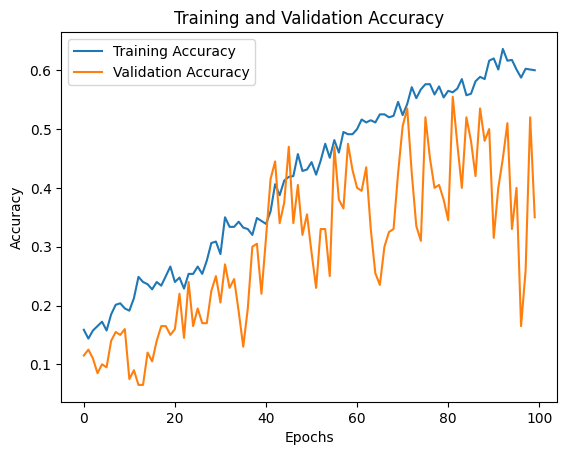

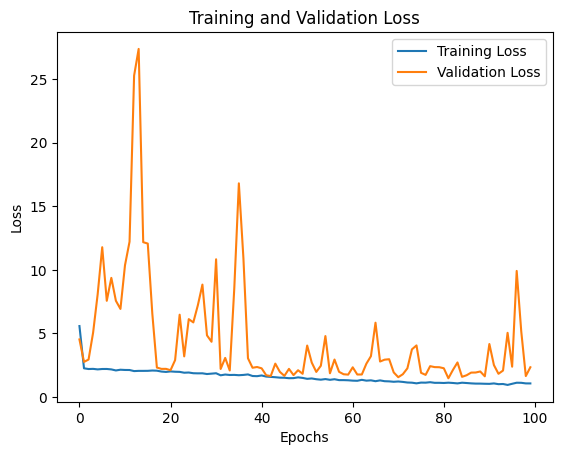

In [19]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


# Imrove the validation %

In [26]:
# Corrected data augmentation functions
def add_noise(audio, noise_level=0.005):
    """Add random noise to the audio."""
    noise = np.random.randn(len(audio))
    return audio + noise_level * noise

def pitch_shift(audio, sr, n_steps=2):
    """Shift the pitch of the audio."""
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)

def time_stretch(audio, rate=1.2):
    """Stretch the time of the audio."""
    return librosa.effects.time_stretch(audio, rate=rate)

In [27]:
# Updated feature extraction with fixed augmentations
def extract_features(file_path, sr=SR, n_mels=N_MELS, duration=DURATION, max_len=MAX_LEN):
    """Extract Mel-spectrogram features with fixed augmentation logic."""
    try:
        audio, _ = librosa.load(file_path, sr=sr, duration=duration)
        features = []
        for augmentation in [None, "noise", "pitch", "stretch"]:
            if augmentation == "noise":
                audio_aug = add_noise(audio)
            elif augmentation == "pitch":
                audio_aug = pitch_shift(audio, sr)
            elif augmentation == "stretch":
                audio_aug = time_stretch(audio, rate=1.2)
            else:
                audio_aug = audio

            # Generate Mel-spectrogram
            mel_spec = librosa.feature.melspectrogram(y=audio_aug, sr=sr, n_mels=n_mels)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

            # Pad or truncate spectrogram
            if mel_spec_db.shape[1] < max_len:
                pad_width = max_len - mel_spec_db.shape[1]
                mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
            else:
                mel_spec_db = mel_spec_db[:, :max_len]

            features.append(mel_spec_db)

        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Load dataset
def load_data(dataset_path):
    features, labels = [], []
    for genre in os.listdir(dataset_path):
        genre_path = os.path.join(dataset_path, genre)
        if os.path.isdir(genre_path):
            for file in os.listdir(genre_path):
                file_path = os.path.join(genre_path, file)
                augmented_features = extract_features(file_path)
                if augmented_features:
                    features.extend(augmented_features)
                    labels.extend([genre] * len(augmented_features))
    return np.array(features), np.array(labels)

# Reload Dataset

In [28]:
# Load features and labels
print("Loading data...")
features, labels = load_data(DATASET_PATH)

Loading data...


In [29]:
# Encode labels and reshape features
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)
categorical_labels = to_categorical(encoded_labels)

features = features[..., np.newaxis]  # Add channel dimension
X_train, X_val, y_train, y_val = train_test_split(features, categorical_labels, test_size=0.2, random_state=42)

print(f"Data loaded: {X_train.shape[0]} training samples, {X_val.shape[0]} validation samples")

Data loaded: 3200 training samples, 800 validation samples


In [30]:

# Build the CNN model
def build_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [31]:
# Model parameters
input_shape = X_train.shape[1:]  # (n_mels, time, 1)
num_classes = len(le.classes_)
# Build the model
model = build_model(input_shape, num_classes)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
# Train the model
BATCH_SIZE = 32
EPOCHS = 500

In [37]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7209 - loss: 0.7549 - val_accuracy: 0.7775 - val_loss: 0.7712
Epoch 2/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7064 - loss: 0.7898 - val_accuracy: 0.7650 - val_loss: 1.0678
Epoch 3/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7260 - loss: 0.7726 - val_accuracy: 0.7075 - val_loss: 1.1228
Epoch 4/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7296 - loss: 0.7628 - val_accuracy: 0.4238 - val_loss: 8.6623
Epoch 5/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7309 - loss: 0.7154 - val_accuracy: 0.6587 - val_loss: 1.7540
Epoch 6/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7071 - loss: 0.7573 - val_accuracy: 0.7262 - val_loss: 2.9334
Epoch 7/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7219 - loss: 0.7779 - val_accuracy: 0.6325 - val_loss: 5.8054
Epoch 8/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7142 - loss: 0.7783 - 

In [38]:
# Save the model and label encoder
model.save("music_genre_model_2.h5")
np.save("label_encoder_2.npy", le.classes_)

In [39]:
# Evaluate the model
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9138 - loss: 1.0601
Validation Accuracy: 90.87%


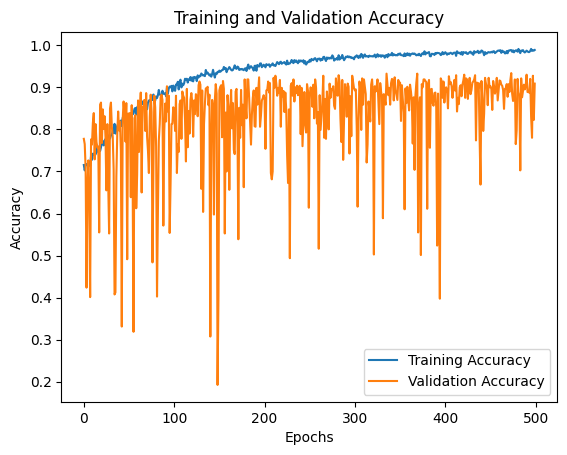

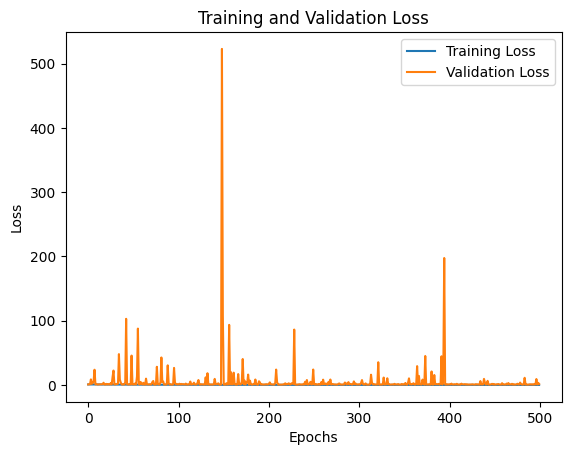

In [40]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


# How to use model

In [42]:
from tensorflow.keras.models import load_model
import numpy as np
import librosa

# Load the trained model and label encoder
model = load_model("music_genre_model_2.h5")
label_classes = np.load("label_encoder_2.npy")

# Function to preprocess and extract features from test audio
def preprocess_audio(file_path, sr=22050, n_mels=128, duration=30, max_len=128):
    """Preprocess test audio and extract Mel-spectrogram."""
    try:
        audio, _ = librosa.load(file_path, sr=sr, duration=duration)
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # Pad or truncate to ensure consistent input shape
        if mel_spec_db.shape[1] < max_len:
            pad_width = max_len - mel_spec_db.shape[1]
            mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mel_spec_db = mel_spec_db[:, :max_len]

        return mel_spec_db[..., np.newaxis]  # Add channel dimension
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


In [43]:
# Path to test audio file
test_audio_path = "/content/genres/classical/classical.00000.au"  # Replace with your test file path

# Preprocess the test audio
test_features = preprocess_audio(test_audio_path)

if test_features is not None:
    # Reshape for prediction
    test_features = np.expand_dims(test_features, axis=0)  # Add batch dimension

    # Predict the genre
    predictions = model.predict(test_features)
    predicted_index = np.argmax(predictions)
    predicted_genre = label_classes[predicted_index]

    print(f"Predicted Genre: {predicted_genre}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
Predicted Genre: classical
